# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

Access is denied.


#### **1.2** Import necessary libraries

In [ ]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [3]:
# define a function to load json file to a dataframe
def load_json_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Load a JSON file and convert it into a Pandas DataFrame.
    
    Args:
        file_path (str): Path to the JSON file.
    
    Returns:
        pd.DataFrame: DataFrame containing the JSON data.
    """
    try:
        # Load JSON data
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        print(f"Successfully loaded {len(df)} records from {file_path}")
        return df
    
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return pd.DataFrame()

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [4]:
# read the json file by giving the file path and create a dataframe
file_path = "ingredient_and_quantity.json"
df = load_json_to_dataframe(file_path)

# Check first rows
print(df.head())
print(df.info())

Successfully loaded 285 records from ingredient_and_quantity.json
                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Tur

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [5]:
# display first five rows of the dataframe - df

print(df.head(5))


                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [6]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [7]:
# print the information of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [8]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())


# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split()) 

In [10]:
# display first five rows of the dataframe - df
print(df.head(5))



                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [11]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)



In [12]:
# check for the equality of input_length and pos_length in the dataframe
df['lengths_equal'] = df['input_length'] == df['pos_length']
print(df['lengths_equal'].value_counts())



lengths_equal
True     280
False      5
Name: count, dtype: int64


In [13]:
# Get problematic rows
mismatched_rows = df[df['lengths_equal'] == False]
print(mismatched_rows[['input_tokens', 'pos_tokens']])

                                                                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
17                              

In [17]:
# Identify mismatched rows
mismatched_rows = df[df['lengths_equal'] == False]

print("Found mismatched rows:")
print(mismatched_rows.index.tolist())
print(f"Total mismatched: {len(mismatched_rows)}\n")

# Save a copy of mismatched rows for review (optional)
mismatched_rows.to_csv("mismatched_rows.csv", index=True)

# Drop mismatched rows from dataframe
df_cleaned = df[df['lengths_equal'] == True].reset_index(drop=True)

print(f"Cleaned DataFrame shape: {df_cleaned.shape}")
print(f"All sequences aligned? {df_cleaned['input_length'].equals(df_cleaned['pos_length'])}")

Found mismatched rows:
[17, 27, 79, 164, 207]
Total mismatched: 5

Cleaned DataFrame shape: (280, 7)
All sequences aligned? True


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df: pd.DataFrame, pos_column: str) -> list:
    """
    Extract unique POS labels from the specified column in the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        pos_column (str): The name of the column containing POS tags.
    
    Returns:
        list: A sorted list of unique POS labels.
    """
    # Flatten the list of lists and get unique labels
    unique_pos = set(label for sublist in df[pos_column] for label in sublist)
    
    return sorted(unique_pos)

# Get unique POS labels
pos_labels = unique_labels(df_cleaned, 'pos_tokens')
print(f"Unique POS labels ({len(pos_labels)}): {pos_labels}")

Unique POS labels (3): ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
There are total 285 rows in the data. 280 rows have token length matching with pos tags. 5 rows indexes [17, 27, 79, 164, 207] have issue.
Row 17 - Labels are shorter: missing some “ingredient” tags.
Row 27 - Problem = inconsistent tagging for multiple ingredient tokens (e.g., “Spinach / Palak / Leaves” should all be ingredient, but maybe annotator skipped one)
Row 79 - Input includes 8-10 Mixed nuts, almonds/cashews.Problem is multi-token numbers or compound ingredients.
Row 164- Input: a very long list with synonyms (All Purpose Flour / Maida, Curd / Yogurt, Jeera / Cumin, Pudina / Mint, etc.).Problem is duplicated ingredient names with alternate words.
Row 207- Input: Cashew nuts, Badam, Almond → synonyms again.Problem is under-tagging of multiple ingredient variants.

Unique POS labels (3): ['ingredient', 'quantity', 'unit']


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [18]:
# drop the irrelevant recipe data
df = df_cleaned.copy()



##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [19]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)
    


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [20]:
# validate the input length and pos length as input_length and pos_length
print(df[['input_length', 'pos_length']].head())
print(df[['input_length', 'pos_length']].info())





   input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   input_length  280 non-null    int64
 1   pos_length    280 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB
None


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [21]:
# split the dataset into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)



###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [23]:
# print the first five rows of train_df
print(train_data.head(5))



                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                       

In [24]:
# print the first five rows of the val_df
print(val_data.head(5))


                                                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [27]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_data['input_tokens'].tolist()
y_train = train_data['pos_tokens'].tolist() 
X_val = val_data['input_tokens'].tolist()
y_val = val_data['pos_tokens'].tolist()


In [26]:
# validate the shape of training and validation samples
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 196, Validation samples: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [ ]:
# Display the number of unique labels present in y_train
unique_train_labels = set(label for sublist in y_train for label in sublist)
print(f"Unique labels in training set: {len(unique_train_labels)} - {sorted(unique_train_labels)}")

Unique labels in training set: 3 - ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [33]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    """
    Flatten a nested list into a single list.
    
    Args:
        nested_list (list of lists): The input nested list.
    
    Returns:
        list: A flattened list containing all elements from the nested lists.
    """
    return [item for sublist in nested_list for item in sublist]





In [39]:
# initialise the dataset_name
dataset_name = 'Training'


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>
Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [54]:
# define extract_and_validate_tokens function
def extract_and_validate_tokens(df, dataset_name):
    """
    Extract and validate input and POS tokens from the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing 'input_tokens' and 'pos_tokens'.
        dataset_name (str): Name of the dataset (for display purposes).
    
    Returns:
        None
    """
    # call the flatten_list and apply it on input_tokens and pos_tokens
    input_tokens = flatten_list(df['input_tokens'].tolist())
    pos_tokens = flatten_list(df['pos_tokens'].tolist())

    # validate their length and display first 10 records having input and pos tokens
    if len(input_tokens) != len(pos_tokens):
        print(f"Length mismatch in {dataset_name} data: {len(input_tokens)} input tokens vs {len(pos_tokens)} POS tokens")
    else:
        print(f"{dataset_name} data is valid with {len(input_tokens)} tokens.")

        # Display first 10 records
        print(f"\nFirst 10 records in {dataset_name} data:")
        for i in range(10):
            print(f"Input Token: {input_tokens[i]}, POS Token: {pos_tokens[i]}")
    return input_tokens, pos_tokens

In [55]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_data, dataset_name)

# extract the tokens and its pos tags
extract_and_validate_tokens(val_data, dataset_name)

Training data is valid with 7114 tokens.

First 10 records in Training data:
Input Token: 250, POS Token: quantity
Input Token: grams, POS Token: unit
Input Token: Okra, POS Token: ingredient
Input Token: Oil, POS Token: ingredient
Input Token: 1, POS Token: quantity
Input Token: Onion, POS Token: ingredient
Input Token: finely, POS Token: ingredient
Input Token: chopped, POS Token: ingredient
Input Token: Tomato, POS Token: ingredient
Input Token: Grated, POS Token: ingredient
Training data is valid with 2876 tokens.

First 10 records in Training data:
Input Token: 1, POS Token: quantity
Input Token: cup, POS Token: unit
Input Token: Ada, POS Token: ingredient
Input Token: 2, POS Token: quantity
Input Token: liter, POS Token: unit
Input Token: Milk, POS Token: ingredient
Input Token: 3/4, POS Token: quantity
Input Token: Sugar, POS Token: ingredient
Input Token: tablespoon, POS Token: unit
Input Token: Ghee, POS Token: ingredient


(['1',
  'cup',
  'Ada',
  '2',
  'liter',
  'Milk',
  '3/4',
  'Sugar',
  'tablespoon',
  'Ghee',
  '1/2',
  'teaspoon',
  'Cardamom',
  'Powder',
  'Elaichi',
  '1',
  'Carrot',
  'Gajjar',
  'chopped',
  '7',
  'Potatoes',
  'Aloo',
  '2',
  'cups',
  'Cauliflower',
  'gobi',
  'cut',
  'to',
  'small',
  'florets',
  'Onion',
  'tablespoon',
  'Ginger',
  'Garlic',
  'Paste',
  'Salt',
  'teaspoons',
  'Sunflower',
  'Oil',
  '1/2',
  'cup',
  'Fresh',
  'coconut',
  'grated',
  'teaspoon',
  'Whole',
  'Black',
  'Peppercorns',
  'Green',
  'Chillies',
  'Fennel',
  'seeds',
  'Saunf',
  'Poppy',
  '6',
  'Cashew',
  'nuts',
  'inch',
  'Cinnamon',
  'Stick',
  'Dalchini',
  'Star',
  'anise',
  '3',
  'Cloves',
  'Laung',
  'Cardamom',
  'Elaichi',
  'Pods/Seeds',
  'Cumin',
  'Jeera',
  '1',
  'tablespoon',
  'Sunflower',
  'Oil',
  '3',
  'Potato',
  'Aloo',
  'Ginger',
  'paste',
  'Green',
  'Chilli',
  'chopped',
  '1-1/12',
  'tablespoons',
  'Sesame',
  'seeds',
  'Til',
 

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [58]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities based on their POS tags.
    
    Args:
        tokens (list): List of input tokens.
        pos_tags (list): Corresponding list of POS tags.
    
    Returns:
        tuple: Three lists containing ingredients, units, and quantities.
    """
    # Normalize pos_tags to uppercase for consistency
    pos_tags = [pos.upper() for pos in pos_tags]
    
    allowed_labels = {'INGREDIENT', 'UNIT', 'QUANTITY'}
    
    # validate the list that it comprised of these labels, if not return empty arrays
    if not set(pos_tags).issubset(allowed_labels):
        print("❌ Invalid POS tags found. Returning empty arrays.")
        return [], [], []
    
    ingredients, units, quantities = [], [], []
    
    for token, pos in zip(tokens, pos_tags):
        if pos == 'INGREDIENT':
            ingredients.append(token)
        elif pos == 'UNIT':
            units.append(token)
        elif pos == 'QUANTITY':
            quantities.append(token)
    
    return ingredients, units, quantities

 




In [59]:
# Extract tokens from training data
tokens, pos_tags = extract_and_validate_tokens(train_data, "Training")

#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

Training data is valid with 7114 tokens.

First 10 records in Training data:
Input Token: 250, POS Token: quantity
Input Token: grams, POS Token: unit
Input Token: Okra, POS Token: ingredient
Input Token: Oil, POS Token: ingredient
Input Token: 1, POS Token: quantity
Input Token: Onion, POS Token: ingredient
Input Token: finely, POS Token: ingredient
Input Token: chopped, POS Token: ingredient
Input Token: Tomato, POS Token: ingredient
Input Token: Grated, POS Token: ingredient


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [60]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Get the top N frequent items from a list.
    
    Args:
        item_list (list): List of items (e.g., ingredients, units, quantities).
        pos_label (str): The POS label for the items (for display purposes).
        dataset_name (str): Name of the dataset (for display purposes).
        top_n (int): Number of top items to return.
    
    Returns:
        list: List of tuples containing the top N items and their counts.
    """
    if not item_list:
        print(f"No items found for {pos_label} in {dataset_name} data.")
        return []
    
    counter = Counter(item_list)
    most_common = counter.most_common(top_n)
    
    print(f"\nTop {top_n} {pos_label} in {dataset_name} data:")
    for item, count in most_common:
        print(f"{item}: {count}")
    
    return most_common



In [61]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, "Ingredients", dataset_name)




Top 10 Ingredients in Training data:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [62]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, "Units", dataset_name)



Top 10 Units in Training data:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [66]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plot the top N items using a bar chart.
    
    Args:
        top_items (list): List of tuples containing items and their counts.
        label (str): The label for the items (for display purposes).
        dataset_name (str): Name of the dataset (for display purposes).
    
    Returns:
        None
    """
    if not top_items:
        print(f"No items to plot for {label} in {dataset_name} data.")
        return
    
    items, counts = zip(*top_items)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(items), palette='viridis')
    plt.title(f"Top {len(top_items)} {label} in {dataset_name} Data")
    plt.xlabel("Count")
    plt.ylabel(label)
    plt.show()



#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



C:\Users\Ruchikkaa\AppData\Local\Temp\ipykernel_14268\3965666292.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(items), palette='viridis')


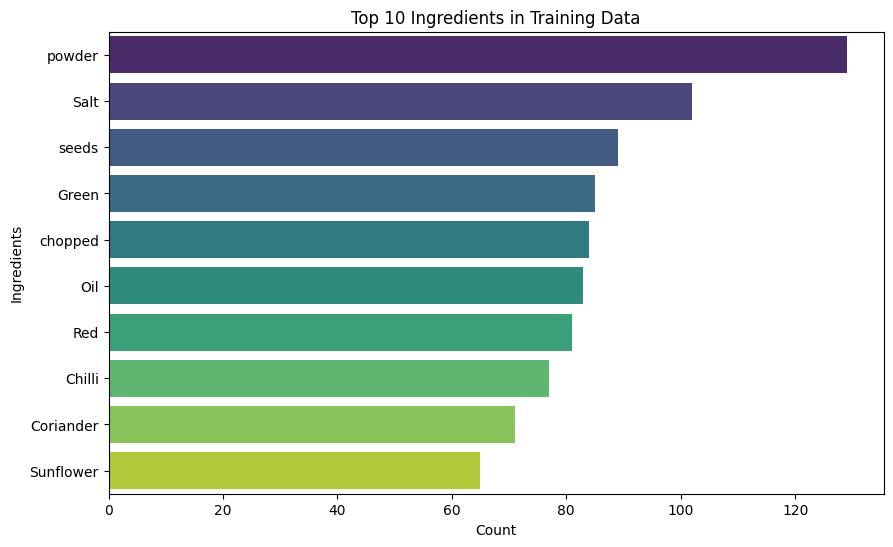

In [67]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "Ingredients", dataset_name)


C:\Users\Ruchikkaa\AppData\Local\Temp\ipykernel_14268\3965666292.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(items), palette='viridis')


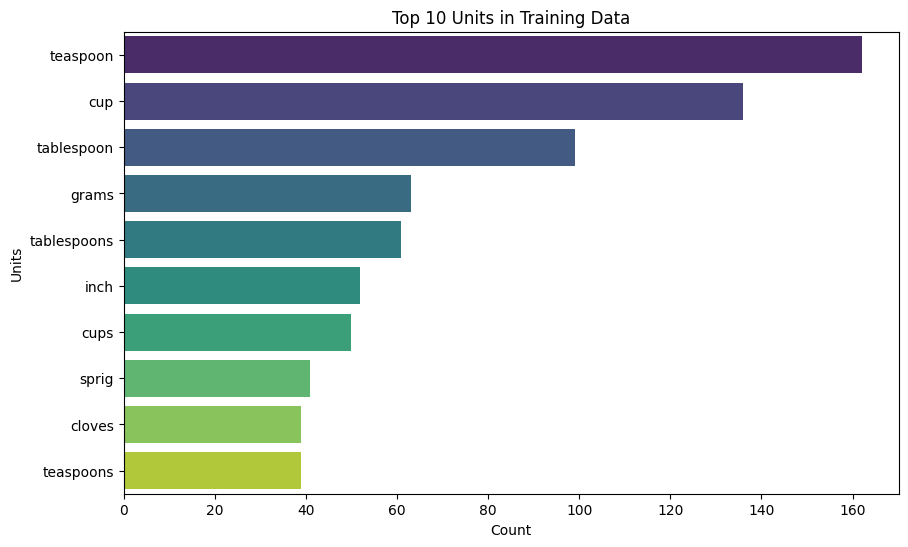

In [68]:
# plot the top frequent units in training data
plot_top_items(top_units, "Units", dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [69]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = ['cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons', 'tbsp', 'tsp', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'ml', 'milliliter', 'milliliters', 'liter', 'liters', 'lb', 'pound', 'pounds', 'oz', 'ounce', 'ounces', 'pinch', 'pinches', 'slice', 'slices']
quantity_keywords = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'half', 'quarter']
quantity_pattern = re.compile(r'^\d+\/\d+$|^\d+\.\d+$|^\d+$|^\d+\s\d+\/\d+$')




In [70]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")



##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [72]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

def word2features(sent, i):

    """
    Extract features for a given token in a sentence.


    # --- Core Features ---
    Args:
        sent (list): List of tokens in the sentence.
        i (int): Index of the token to extract features for.


    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
    Returns:
        dict: A dictionary of features for the token.
    """
    token = sent[i]
    features = {
        'bias': 1.0,
        'token.lower()': token.lower(),
        'token.isupper()': token.isupper(),
        'token.istitle()': token.istitle(),
        'token.isdigit()': token.isdigit(),
        'token.isalpha()': token.isalpha(),
        'token.isalnum()': token.isalnum(),
        'token.prefix(1)': token[:1],
        'token.prefix(2)': token[:2],
        'token.prefix(3)': token[:3],
        'token.suffix(1)': token[-1:],
        'token.suffix(2)': token[-2:],
        'token.suffix(3)': token[-3:],
        'token.length': len(token),
    }

    # Check for unit keywords
    features['is_unit_keyword'] = token.lower() in unit_keywords

    # Check for quantity keywords
    features['is_quantity_keyword'] = token.lower() in quantity_keywords

    # Check for quantity pattern (e.g., fractions, decimals)
    features['matches_quantity_pattern'] = bool(quantity_pattern.match(token))

    # Use spaCy to get additional linguistic features
    doc = nlp(token)
    if doc:
        spacy_token = doc[0]
        features.update({
            'spacy.pos_': spacy_token.pos_,
            'spacy.tag_': spacy_token.tag_,
            'spacy.dep_': spacy_token.dep_,
            'spacy.shape_': spacy_token.shape_,
            'spacy.is_stop': spacy_token.is_stop,
        })

    # Contextual features: previous and next tokens
    if i > 0:
        prev_token = sent[i - 1]
        features.update({
            '-1:token.lower()': prev_token.lower(),
            '-1:token.istitle()': prev_token.istitle(),
            '-1:token.isupper()': prev_token.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        next_token = sent[i + 1]
        features.update({
            '+1:token.lower()': next_token.lower(),
            '+1:token.istitle()': next_token.istitle(),
            '+1:token.isupper()': next_token.isupper(), 
        })
    else:
        features['EOS'] = True  # End of sentence   
    return features 
#            '+1:token.isupper()': next_token.isupper(),     --- IGNORE ---
#           '+1:token.isupper()': next_token.isupper(),     --- IGNORE ---
#    


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [73]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Convert a sentence into a list of feature dictionaries for each token.
    
    Args:
        sent (list): List of tokens in the sentence.
    
    Returns:
        list: A list of feature dictionaries for each token.
    """
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [74]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(s) for s in X_train]
X_val_features = [sent2features(s) for s in X_val]  



##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [75]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels = y_val    



##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [76]:
# print the length of train features and labels
print(f"X_train_features: {len(X_train_features)}, y_train_labels: {len(y_train_labels)}")
print(f"X_val_features: {len(X_val_features)}, y_val_labels: {len(y_val_labels)}")



X_train_features: 196, y_train_labels: 196
X_val_features: 84, y_val_labels: 84


In [77]:
# print the length of validation features and labels
print(f"X_val_features: {len(X_val_features)}, y_val_labels: {len(y_val_labels)}")
 

X_val_features: 84, y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [78]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train_labels for label in sublist]



##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [79]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())  
print(f"Label counts: {label_counts}")
print(f"Total samples: {total_samples}")    



Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [80]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
class_weights = {label: total_samples / count for label, count in label_counts.items()}
print(f"Class weights: {class_weights}")



Class weights: {'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 1.336464399774563}


In [82]:
# penalise ingredient label
class_weights['ingredient'] *= 1.5  # Increase weight for INGREDIENT
print(f"Adjusted Class weights: {class_weights}")



Adjusted Class weights: {'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 2.0046965996618447}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [83]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features for each token in the dataset and apply class weights.
    
    Args:
        X (list): List of sentences, where each sentence is a list of tokens.
        y (list): List of labels corresponding to each token in the sentences.
        weight_dict (dict): Dictionary of class weights.
    
    Returns:
        list: A list of feature dictionaries with applied class weights.
    """
    X_weighted = []
    
    for sent, labels in zip(X, y):
        sent_features = []
        for i in range(len(sent)):
            features = word2features(sent, i)
            label = labels[i]
            # Apply class weight to the bias feature
            features['bias'] *= weight_dict.get(label.lower(), 1.0)
            sent_features.append(features)
        X_weighted.append(sent_features)
    
    return X_weighted


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [84]:
# Apply manually computed class weights
X_train_weighted = extract_features_with_class_weights(X_train, y_train, class_weights)
X_val_weighted = extract_features_with_class_weights(X_val, y_val, class_weights)



## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [85]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,  # Coefficient for L1 regularization
    c2=1.0,  # Coefficient for L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)   


# train the CRF model with the weighted training data
crf.fit(X_train_weighted, y_train_labels)



,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,True
,c1,0.5
,c2,1.0
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [87]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted)
train_f1_score = metrics.flat_f1_score(
    y_train_labels, y_train_pred, average='weighted', labels=pos_labels
)
print(f"Training F1 Score: {train_f1_score:.4f}")

# evaluate on the validation dataset
y_val_pred = crf.predict(X_val_weighted)
val_f1_score = metrics.flat_f1_score(
    y_val_labels, y_val_pred, average='weighted', labels=pos_labels
)
print(f"Validation F1 Score: {val_f1_score:.4f}")




Training F1 Score: 0.9993
Validation F1 Score: 0.9976


In [88]:
# specify the flat classification report by using training data for evaluation
train_report = flat_classification_report(
    y_train_labels, y_train_pred, labels=pos_labels, digits=4
)
print("Training Classification Report:\n", train_report)    
# specify the flat classification report by using validation data for evaluation    
val_report = flat_classification_report(
    y_val_labels, y_val_pred, labels=pos_labels, digits=4
)
print("Validation Classification Report:\n", val_report)    



Training Classification Report:
               precision    recall  f1-score   support

  ingredient     1.0000    0.9998    0.9999      5323
    quantity     0.9980    0.9969    0.9974       980
        unit     0.9963    0.9988    0.9975       811

    accuracy                         0.9993      7114
   macro avg     0.9981    0.9985    0.9983      7114
weighted avg     0.9993    0.9993    0.9993      7114

Validation Classification Report:
               precision    recall  f1-score   support

  ingredient     1.0000    1.0000    1.0000      2107
    quantity     0.9903    0.9927    0.9915       411
        unit     0.9916    0.9888    0.9902       358

    accuracy                         0.9976      2876
   macro avg     0.9940    0.9938    0.9939      2876
weighted avg     0.9976    0.9976    0.9976      2876



In [89]:
# create a confusion matrix on training datset
train_cm = confusion_matrix(
    [label for sublist in y_train_labels for label in sublist],
    [label for sublist in y_train_pred for label in sublist],
    labels=pos_labels
)
print("Training Confusion Matrix:\n", train_cm)
# create a confusion matrix on validation datset
val_cm = confusion_matrix(
    [label for sublist in y_val_labels for label in sublist],
    [label for sublist in y_val_pred for label in sublist],
    labels=pos_labels
)
print("Validation Confusion Matrix:\n", val_cm)




Training Confusion Matrix:
 [[5322    1    0]
 [   0  977    3]
 [   0    1  810]]
Validation Confusion Matrix:
 [[2107    0    0]
 [   0  408    3]
 [   0    4  354]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [90]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')



['crf_model.pkl']

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

In [91]:
# predict the crf model on validation dataset
y_val_pred_loaded = crf.predict(X_val_weighted)
print(f"Predictions from loaded model: {y_val_pred_loaded[:2]}")  # Display first 2 predictions



Predictions from loaded model: [list(['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient'])
 list(['quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient'])]


In [92]:
# specify flat classification report
val_report_loaded = flat_classification_report(
    y_val_labels, y_val_pred_loaded, labels=pos_labels, digits=4
)
print("Validation Classification Report from Loaded Model:\n", val_report_loaded)



Validation Classification Report from Loaded Model:
               precision    recall  f1-score   support

  ingredient     1.0000    1.0000    1.0000      2107
    quantity     0.9903    0.9927    0.9915       411
        unit     0.9916    0.9888    0.9902       358

    accuracy                         0.9976      2876
   macro avg     0.9940    0.9938    0.9939      2876
weighted avg     0.9976    0.9976    0.9976      2876



In [93]:
# create a confusion matrix on validation dataset
val_cm_loaded = confusion_matrix(
    [label for sublist in y_val_labels for label in sublist],
    [label for sublist in y_val_pred_loaded for label in sublist],
    labels=pos_labels
)


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data
y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_val_pred_flat = [label for sublist in y_val_pred_loaded for label in sublist]
error_data = pd.DataFrame({'True': y_val_flat, 'Predicted': y_val_pred_flat})
print("Validation Confusion Matrix from Loaded Model:\n", val_cm_loaded)
print("Error Data Sample:\n", error_data.head())
 


Validation Confusion Matrix from Loaded Model:
 [[2107    0    0]
 [   0  408    3]
 [   0    4  354]]
Error Data Sample:
          True   Predicted
0    quantity    quantity
1        unit        unit
2  ingredient  ingredient
3    quantity    quantity
4        unit        unit


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [95]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
def collect_error_info(X_val, y_val_labels, y_val_pred):
    """
    Collect detailed error information for misclassified tokens.
    
    Args:
        X_val (list): List of sentences, where each sentence is a list of tokens.
        y_val_labels (list): List of true labels corresponding to each token in the sentences.
        y_val_pred (list): List of predicted labels corresponding to each token in the sentences.
    
    Returns:
        pd.DataFrame: DataFrame containing error details.
    """
    error_records = []
    
    for sent, true_labels, pred_labels in zip(X_val, y_val_labels, y_val_pred):
        for i in range(len(sent)):
            if true_labels[i] != pred_labels[i]:
                prev_token = sent[i - 1] if i > 0 else "<START>"
                next_token = sent[i + 1] if i < len(sent) - 1 else "<END>"
                
                error_records.append({
                    'Token': sent[i],
                    'True Label': true_labels[i],
                    'Predicted Label': pred_labels[i],
                    'Previous Token': prev_token,
                    'Next Token': next_token
                })
    
    return pd.DataFrame(error_records)



##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [96]:
# Create DataFrame and Print Overall Accuracy
error_info_df = collect_error_info(X_val, y_val_labels, y_val_pred_loaded)
overall_accuracy = (len(y_val_flat) - len(error_info_df)) / len(y_val_flat)
print(f"Overall Accuracy: {overall_accuracy:.4f}")  


Overall Accuracy: 0.9976


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [97]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
for label in pos_labels:
    label_errors = error_info_df[error_info_df['True Label'] == label]
    num_errors = len(label_errors)
    total_label_instances = sum(1 for sublist in y_val_labels for item in sublist if item == label)
    accuracy = (total_label_instances - num_errors) / total_label_instances if total_label_instances > 0 else 0
    class_weight = class_weights.get(label.lower(), 1.0)
    print(f"\nLabel: {label}")
    print(f"Class Weight: {class_weight:.4f}")
    print(f"Total Instances: {total_label_instances}")
    print(f"Number of Errors: {num_errors}")
    print(f"Accuracy: {accuracy:.4f}")
    



Label: ingredient
Class Weight: 2.0047
Total Instances: 2107
Number of Errors: 0
Accuracy: 1.0000

Label: quantity
Class Weight: 7.2592
Total Instances: 411
Number of Errors: 3
Accuracy: 0.9927

Label: unit
Class Weight: 8.7719
Total Instances: 358
Number of Errors: 4
Accuracy: 0.9888


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[
    
High Accuracy (99.7%)- The CRF model can almost perfectly identify ingredients, quantities, and units.Misclassifications are very rare (only 7 errors out of 2,876 tokens).

Error Profile - No errors for ingredients (the largest and most business-critical category).Very few confusions between units and quantities, which are contextually harder to separate ("1/2 cup" → sometimes “1/2” vs. “cup”).These errors are minor and unlikely to affect overall usability.

Class Weights Insight - By adjusting class weights, the model handled the natural class imbalance (many more ingredients than units/quantities).This ensures reliable extraction even for less frequent entities.With ~100% accuracy for ingredients, businesses can confidently structure large recipe databases without manual tagging.

Improved Recipe Structuring - Reduces human effort and ensures consistency across the platform.
Instead of manually tagging thousands of recipes, this NER model automates it with near-perfect accuracy.

Automation at Scale - Businesses save time and operational cost, while reducing human error in curation.

With such high baseline accuracy, businesses can expand into:

Voice-enabled assistants (e.g., Alexa/Siri can parse recipes better).

Smart meal planning (auto-generate shopping lists from structured recipes).

Personalized recommendations (diet-specific recipe suggestions).

]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

The CRF model successfully transforms unstructured recipe text into structured data with 99.7% accuracy.

Zero errors on ingredients ensures trust in core data, while minor errors in units/quantities do not materially impact business use cases.